In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
from IPython import display
from PIL import Image
from mlib.Cat import *
from config import *
import pandas as pd
from pd.CSV import CSV

images = os.listdir(Input_ImgDir)
No_imgs_in_folder = len(images)

def cv2_imshow(a):
  """A replacement for cv2.imshow() for use in Jupyter notebooks.

  Args:
    a : np.ndarray. shape (N, M) or (N, M, 1) is an NxM grayscale image. shape
      (N, M, 3) is an NxM BGR color image. shape (N, M, 4) is an NxM BGRA color
      image.
  """
  a = a.clip(0, 255).astype('uint8')
  # cv2 stores colors as BGR; convert to RGB
  if a.ndim == 3:
    if a.shape[2] == 4:
      a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
    else:
      a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  display.display(Image.fromarray(a))

def markPoint(pc, image, color = (120,255,0)):
    for i in range(pc.shape[0]):
       cv2.circle(image, (pc[i][0],pc[i][1]) , 1,color, -1)
    return image

In [2]:

pc = cat([],np.array([[152, 3],[152, 36]]))
print(pc)
# print(pc.astype(np.int64))
# print(pc[-1])

#rc = np.flip(pc, 0)
#print(rc[:-1])


[[152   3]
 [152  36]]


In [3]:
pc = cat(pc,np.array([152, 36]))
print(pc)

[[152   3]
 [152  36]
 [152  36]]


In [4]:
queries = torch.tensor([
        [0., 400., 350.],  # point tracked from the first frame
        [10., 600., 500.], # frame number 10
        [20., 750., 600.], # ...
        [30., 900., 200.]
    ])

In [5]:
def keypointUpdate(idx_t, pc_t, idx_curnt, pc_added, idx_added):
    '''
    idx_t : previous tracked index (initial keypoint indexes used for co-tracker)
            (indexes before modifiying pw.xlsx)
    pc_t : co-trcker output keypoint predictions 

    idx_curnt : All modified indexes for current frame want to be tracked for future
                (indexes after modifiying pw.xlsx)
    pc_added : Newly added/ modified keypoints
    idx_added : indexes of newly added/ modified keypoints

    '''
    
    idx_common = np.intersect1d(idx_t,idx_curnt) # common idx current and previos
    pc_curr_comm = pc_t[np.in1d(idx_t,idx_curnt)]
    pc_all_t = np.concatenate((np.expand_dims(idx_common, axis=1),pc_curr_comm), axis=1) # all keypoints which is tracked

    pc_all_added = np.concatenate((np.expand_dims(idx_added, axis=1),pc_added), axis=1)
    pc_all_added_sort = pc_all_added[pc_all_added[:, 0].argsort()]
    modified_tracked = np.in1d(pc_all_added_sort[:, 0], idx_common)
    pc_all_new = pc_all_added_sort[np.invert(modified_tracked)]
    
    modified_tracked_comm = np.in1d(idx_common, pc_all_added_sort[:, 0])
    '''copy modified common keypoints'''
    pc_all_t[modified_tracked_comm]=pc_all_added_sort[modified_tracked]

    new_pc = np.concatenate((pc_all_t,pc_all_new), axis=0).astype(np.int32)
    new_pc_organized  = new_pc[new_pc[:, 0].argsort()] # idx sorting
    return new_pc_organized

pc_prev :  (17, 2)


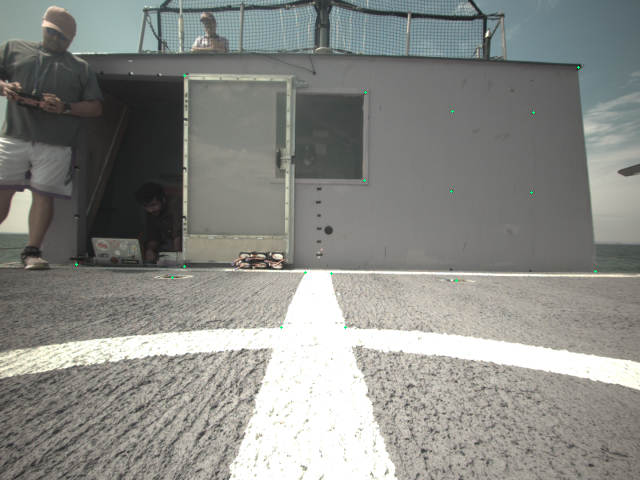

15
16
pc_t73 :  (17, 2)
pc_n_73 :  (3, 2)


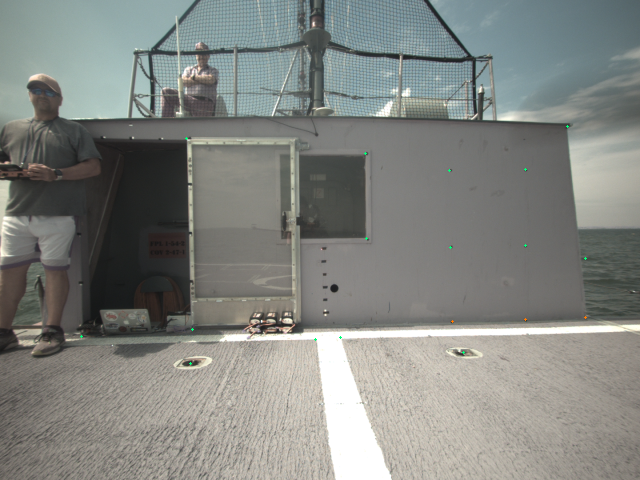

[[585 317]
 [525 319]
 [452 321]]


In [6]:
idx_prev = np.array([ 1., 10., 14., 17., 18., 23., 24., 26., 27., 28., 29., 31., 36., 37., 38., 39., 40.])
pc_prev = np.array([[ 76, 264],
                    [184,  75],
                    [184, 266],
                    [365,  92],
                    [364, 180],
                    [578,  67],
                    [595, 271],
                    [451, 191],
                    [452, 111],
                    [533, 112],
                    [531, 192],
                    [172, 277],
                    [456, 280],
                    [305, 272],
                    [281, 327],
                    [345, 327],
                    [331, 273]])
idxpc_prev = np.concatenate((np.expand_dims(idx_prev, axis=1),pc_prev), axis=1)
print("pc_prev : ",pc_prev.shape)
img_No = 1
im = cv2.imread(Input_ImgDir+ "{:06}.jpg".format(img_No))
markPoint(pc_prev, im)
cv2_imshow(im)

idx_t73 = np.array([ 1., 10., 14., 17., 18., 23., 24., 25., 26., 27., 28., 29., 30., 31., 36., 37., 40.])
pc_t73 = np.array([[ 81, 336],
                    [186, 138],
                    [192, 329],
                    [365, 153],
                    [366, 238],
                    [567, 126],
                    [585, 258],
                    [450, 247],
                    [449, 170],
                    [525, 169],
                    [525, 245],
                    [190, 363],
                    [463, 352],
                    [315, 339],
                    [332, 493],
                    [390, 482],
                    [340, 337]])

idxpc_t73 = np.concatenate((np.expand_dims(idx_t73, axis=1),pc_t73), axis=1)

for i in range(pc_t73.shape[0]):
    [x,y] = pc_t73[i]
    if x < 0 or x > 640 or y < 0 or y > 480:
        print(i+1)
        
idx_new_73 = np.array([24, 30, 25])
pc_new_73 = np.array([[585, 317],
                    [525, 319],
                    [452, 321]])
print("pc_t73 : ",pc_t73.shape)
print("pc_n_73 : ",pc_new_73.shape)

img_No = 73
im = cv2.imread(Input_ImgDir+ "{:06}.jpg".format(img_No))
markPoint(pc_t73, im)
markPoint(pc_new_73, im, (0,120,255))
cv2_imshow(im)
print(pc_new_73)


pc_expect73 :  (17, 2)


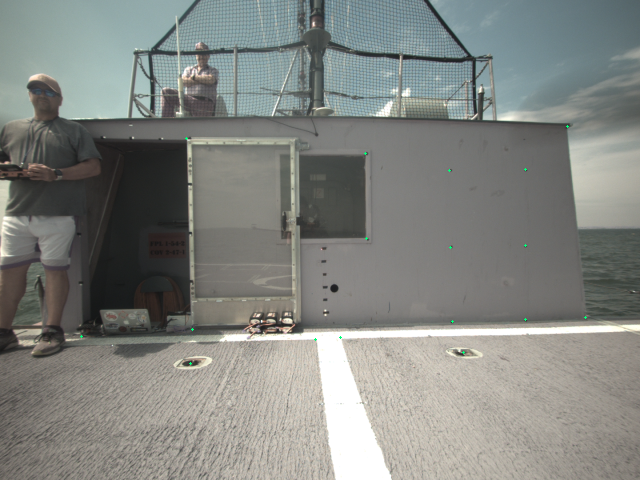

In [7]:
pc_expect73 = np.array([[ 81, 336],
                        [186, 138],
                        [192, 329],
                        [365, 153],
                        [366, 238],
                        [567, 126],
                        [585, 317],
                        [452, 321],
                        [450, 247],
                        [449, 170],
                        [525, 169],
                        [525, 245],
                        [525, 319],
                        [190, 363],
                        [463, 352],
                        [315, 339],
                        [340, 337]])
print("pc_expect73 : ",pc_expect73.shape)
img_No = 73
im = cv2.imread(Input_ImgDir+ "{:06}.jpg".format(img_No))
markPoint(pc_expect73, im)
# markPoint(pc_n_73, im, (0,120,255))
cv2_imshow(im)

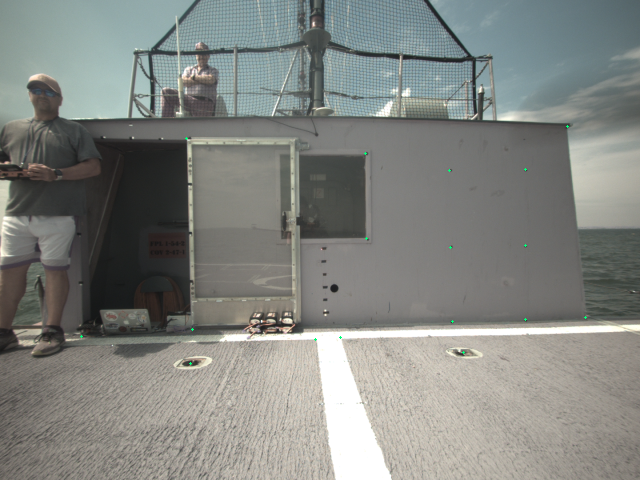

In [8]:
df = pd.read_excel('pw.xlsx',header=0, sheet_name='All')
csv = CSV(df)
pc_73_up = keypointUpdate(idx_prev, pc_t73, csv.idx, pc_new_73, csv.nidx)
img_No = 73
im = cv2.imread(Input_ImgDir+ "{:06}.jpg".format(img_No))
markPoint(pc_73_up[:,1:3], im)
# markPoint(pc_n_73, im, (0,120,255))
cv2_imshow(im)

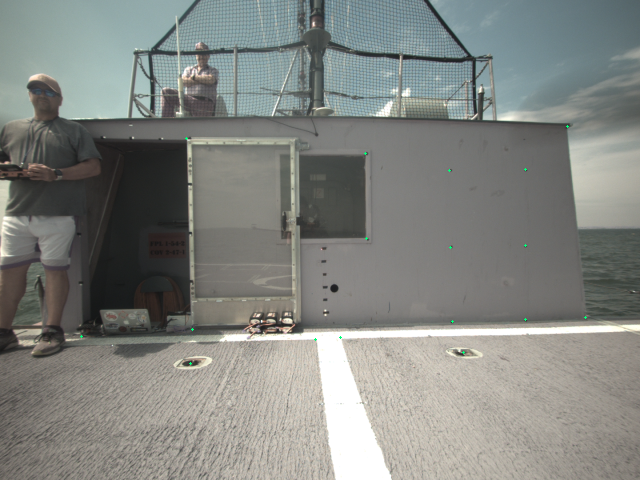

In [9]:
df = pd.read_excel('pw.xlsx',header=0, sheet_name='All')
csv = CSV(df)
pc_73_up2 = keypointUpdate(pc_73_up[:,0], pc_73_up[:,1:3], csv.idx, pc_new_73, csv.nidx)
img_No = 73
im = cv2.imread(Input_ImgDir+ "{:06}.jpg".format(img_No))
markPoint(pc_73_up2[:,1:3], im)
# markPoint(pc_n_73, im, (0,120,255))
cv2_imshow(im)

In [10]:
print(pc_73_up2-pc_73_up)

[[0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]]


In [11]:
df = pd.read_excel('pw.xlsx',header=0, sheet_name='All')
csv = CSV(df)
PW = csv.Pw
print(PW.shape)

(17, 3)


In [12]:
idx_curnt = csv.idx
print(idx_curnt)
idx_new = csv.nidx
print(idx_new)


[ 1. 10. 14. 17. 18. 23. 24. 25. 26. 27. 28. 29. 30. 31. 36. 37. 40.]
[24 30 25]


### Tracked

In [13]:
idx_t = np.array([1, 2, 3, 4, 5]) # previous frame keypoints indexes 
pc_t = np.array([[ 76, 264],
                 [184,  76],
                 [183, 265],
                 [183, 265],
                 [367,  91]])

### Current 
- Some keys from Tracked `pc_t` may not presented (deleted)
- Some keys from Tracked `pc_t` may modified (modified)
$- There will be unchanged keypoints
- There will be additional keypoints


In [14]:
idx_curnt = csv.idx # current frame keypoints indexes 
print("idx_tracked ",idx_t)
print("idx_curnt ",idx_curnt)

idx_common = np.intersect1d(idx_t,idx_curnt) # common idx current and previos
print("idx_common ",idx_common)
comm_curr = np.in1d(idx_curnt,idx_t)
print("bool comm_curr : ",comm_curr)
comm_tr = np.in1d(idx_t,idx_curnt)
print("bool comm_tr : ",comm_tr)
pc_curr_comm = pc_t[comm_tr]
print(pc_curr_comm)
pc_all_t = np.concatenate((np.expand_dims(idx_common, axis=1),pc_curr_comm), axis=1)

print("idx | pc_comm_track : ", pc_all_t)

idx_tracked  [1 2 3 4 5]
idx_curnt  [ 1. 10. 14. 17. 18. 23. 24. 25. 26. 27. 28. 29. 30. 31. 36. 37. 40.]
idx_common  [1.]
bool comm_curr :  [ True False False False False False False False False False False False
 False False False False False]
bool comm_tr :  [ True False False False False]
[[ 76 264]]
idx | pc_comm_track :  [[  1.  76. 264.]]


In [15]:
pc_added = np.array([[530, 271],
                [450, 269],
                 [530, 271],
                [530, 271]]) # new keypoints

idx_added = csv.nidx
print(idx_added)

pc_all_added = np.concatenate((np.expand_dims(idx_added, axis=1),pc_added), axis=1)
print("pc_added unsorted",pc_all_added)

pc_all_added_sort = pc_all_added[pc_all_added[:, 0].argsort()]#[:, 0]
print("pc_added sorted",pc_all_added_sort)


modified_tracked = np.in1d(pc_all_added_sort[:, 0], idx_common)
print("bool modified_tracked : ",modified_tracked)
pc_m = pc_added[modified_tracked]
print("pc_modified : ",pc_m)

added_keys = np.invert(modified_tracked)
print("bool added new keys : ",added_keys)
pc_all_new = pc_all_added_sort[added_keys]
print("pc_added/ included : ",pc_all_new)

[24 30 25]


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 3 and the array at index 1 has size 4

In [ ]:
modified_tracked_comm = np.in1d(idx_common, pc_all_added_sort[:, 0])
print("bool modified_tracked comm: ",modified_tracked_comm)
pc_mm = pc_curr_comm[modified_tracked_comm]
print("pc_modified : ",pc_mm)

bool modified_tracked comm:  [ True False  True]
pc_modified :  [[ 76 264]
 [367  91]]


In [ ]:
'''modified common keypoints'''
pc_all_t[modified_tracked_comm]=pc_all_added_sort[modified_tracked]
print(pc_all_t)

[[  1. 530. 271.]
 [  3. 183. 265.]
 [  5. 450. 269.]]


In [ ]:
'''newly added keypoints'''
print("pc_added/ included : ",pc_all_new)

pc_added/ included :  [[  6 530 271]
 [  7 530 271]]


#### inputs

In [ ]:
idx_t = np.array([1, 2, 3, 4, 5]) # previous frame keypoints indexes 
pc_t = np.array([[ 76, 264],
                 [123,  76],
                 [155, 265],
                 [183, 235],
                 [367,  91]]) # co-tracked keypoints

idx_curnt = csv.idx # current frame all keypoints indexes 

pc_added = np.array([[50, 61],
                [450, 269],
                 [530, 271],
                [510, 171]]) # newly added keypoints at pre defined order

idx_added = csv.nidx


In [ ]:
def keypointUpdate(idx_t, pc_t, idx_curnt, pc_added, idx_added):
    idx_common = np.intersect1d(idx_t,idx_curnt) # common idx current and previos
    pc_curr_comm = pc_t[np.in1d(idx_t,idx_curnt)]
    pc_all_t = np.concatenate((np.expand_dims(idx_common, axis=1),pc_curr_comm), axis=1) # all keypoints which is tracked

    pc_all_added = np.concatenate((np.expand_dims(idx_added, axis=1),pc_added), axis=1)
    pc_all_added_sort = pc_all_added[pc_all_added[:, 0].argsort()]
    modified_tracked = np.in1d(pc_all_added_sort[:, 0], idx_common)
    pc_all_new = pc_all_added_sort[np.invert(modified_tracked)]
    
    modified_tracked_comm = np.in1d(idx_common, pc_all_added_sort[:, 0])
    '''copy modified common keypoints'''
    pc_all_t[modified_tracked_comm]=pc_all_added_sort[modified_tracked]

    new_pc = np.concatenate((pc_all_t,pc_all_new), axis=0)
    return new_pc

In [ ]:
idx_common = np.intersect1d(idx_t,idx_curnt) # common idx current and previos
pc_curr_comm = pc_t[np.in1d(idx_t,idx_curnt)]
pc_all_t = np.concatenate((np.expand_dims(idx_common, axis=1),pc_curr_comm), axis=1) # all keypoints which is tracked

pc_all_added = np.concatenate((np.expand_dims(idx_added, axis=1),pc_added), axis=1)
pc_all_added_sort = pc_all_added[pc_all_added[:, 0].argsort()]
modified_tracked = np.in1d(pc_all_added_sort[:, 0], idx_common)
pc_m = pc_added[modified_tracked]
pc_all_new = pc_all_added_sort[np.invert(modified_tracked)]

'''copy modified common keypoints'''
pc_all_t[modified_tracked_comm]=pc_all_added_sort[modified_tracked]

new_pc = np.concatenate((pc_all_t,pc_all_new), axis=0)
print(new_pc)

[[  1. 510. 171.]
 [  3. 155. 265.]
 [  5. 450. 269.]
 [  6. 530. 271.]
 [  7.  50.  61.]]


[[  1. 530. 271.]
 [  3. 183. 265.]
 [  5. 450. 269.]
 [  6. 530. 271.]
 [  7. 530. 271.]]

In [ ]:
# def ModifiedTrackedKeys(idx_curnt):

#     pc_all_t = np.concatenate((np.expand_dims(idx_common, axis=1),pc_curr_comm), axis=1)

In [ ]:
# pc_idx = np.concatenate((np.expand_dims(idx_curnt, axis=1),pc), axis=1)
# pc_n_idx = np.concatenate((np.expand_dims(idx_new, axis=1),pc_n), axis=1)

In [ ]:
print(pc.shape)
print(pc_n.shape)

(3, 2)


NameError: name 'pc_n' is not defined

In [ ]:
idx_common = np.intersect1d(idx_prev,idx_curnt)
print(idx_common)
comm_A = np.in1d(idx_curnt,idx_prev)
print(comm_A)
idx_modified = np.intersect1d(idx_common,idx_new)
print(idx_modified)
idx_add = np.setdiff1d(idx_new, idx_modified)
print(idx_add)

NameError: name 'idx_prev' is not defined

In [ ]:
pos = 0
n_pos = 0
pcs=[]
print(pc.shape)

for i, idx in enumerate(csv.idx):
    old_p = True
    for j, nidx in enumerate(csv.nidx):
        if idx == nidx:
            print(i, idx,nidx, " pcn: ", pc_n[j])
            old_p = False
            pos+=1
    if old_p:
        if pos < pc.shape[0]:
            print(i, idx,nidx, " pc: ", pc[pos])
            cat(pcs,pc[pos])
        else:
            print(pos)
        pos+=1

(13, 2)
0 1.0 3  pc:  [ 76 264]
1 3.0 3  pcn:  [530 271]
2 4.0 3  pc:  [183 265]
3 5.0 5  pcn:  [450 269]


In [ ]:
cat(pc,rc[-1])

NameError: name 'rc' is not defined